# Importar datos
Montamos nuestro drive.

In [3]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Facultad/Tesis

/content/drive/MyDrive/Facultad/Tesis


# Cargar dataset


In [25]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Set paths
DATADIR = 'data/'

## Dataset FSI

In [6]:
DATASET = join(DATADIR, 'multivariate.csv')
fsi = pd.read_csv(DATASET)
fsi = fsi.astype(int)
# Set target
target = 'DEF'
fsi

,DEF,CALI,DIVD,DLI,EMB,MONT,PINT,SOLD,SQF,APR,ASP,DGRC,ELEC,ESTQ,FCIO,FLDS,FTES,GMTR,MOP,NCON,RDOS
0,2,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,5,0,0,3,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,1,0,0,0
3,10,0,0,0,0,0,0,10,0,0,9,1,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,7,0,0,7,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,9,0,0,0,0,5,4,0,0,0,4,4,0,0,0,0,0,0,1,0,0
3636,16,0,0,0,1,6,6,3,0,0,12,2,0,0,0,0,0,1,1,0,0
3637,15,0,0,0,0,4,7,4,0,0,6,1,1,0,0,0,0,3,1,2,1
3638,11,1,0,0,0,0,7,3,0,0,8,0,1,0,0,0,0,2,0,0,0


## Dataset de polución del aire

In [8]:
from pandas import read_csv
from datetime import datetime
from IPython.display import display
from sklearn.preprocessing import LabelEncoder

DATASET = join(DATADIR, 'pollution.csv')

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
df = read_csv(DATASET,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)

# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
df = df[24:]

# Set target
target = 'pollution'

# Encode labels
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df['wnd_dir'] = labelencoder.fit_transform(df['wnd_dir'])

# Define dataset as float
df = df.astype(float)

# save to file
#dataset.to_csv('pollution.csv')

# Cálculo de la entropía
A través de los algoritmos de ```ApEn``` y ```SampEn``` calcularemos la entropía de las dos series temporales utilizadas. Además se hará una comparación entre los tiempos de ejecución entre la popular librería ```NumPy``` y ```CuPy```, librería que nos ofrece poder utilizar GPU en nuestros cálculos matriciales.

## Métodos
Es necesario definir un método para normalizar la serie temporal y obtener el valor $r$.

In [12]:
def params_entropy(u:np.array, m:int, r_rate:float):
  """        
  Calculates approximate entropy (ApEn) of a time series.

  Input
      u: Raw time series
      m: Template length
      r_rate: Constant for r compute

  Output: 
      u: Normalized time series
      m: Template length
      r: Tolerance level
  """

  # Normalize time series
  u_mean = np.mean(u)
  u_std = np.std(u)
  u = u-u_mean/u_std
  u = np.array(u)

  # Compute r
  r = r_rate*u_std

  return u, m, r

In [13]:
from typing import Callable
import time

def compute_time(func: Callable, u:np.array, m:int, r_rate:float)->float:
  """        
    Calculate execution time of function. 
    The function parameters are necessary.

    Input
    func: Function to test
    u: Raw time series
    m: Template length
    r_rate: Tolerance level

    Output: 
    t: Time execution of function
  """
  # start
  s = time.time()
  # compute
  func(u, m, r)
  # end
  e = time.time()
  # result
  t = e-s
  return t

## NumPy

### ApEn

In [14]:
def apen_np(L, m, r) -> float:
  """        
    Calculates approximate entropy (ApEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        ApEn
  """

  N = len(L)

  # Divide time series and save all templates of length m
  xmi = np.array([L[i:i+m] for i in range(N-m)])
  xmj = np.array([L[i:i+m] for i in range(N-m+1)])

  # Compute each B_i            
  B = [np.sum(np.abs(xmii-xmj).max(axis=1) <= r) for xmii in xmi]

  # Similar method to compute each A_i
  m += 1
  xm = np.array([L[i:i+m] for i in range(N-m+1)])

  A = [np.sum(np.abs(xmi-xm).max(axis=1) <= r) for xmi in xm]
    
  # Compute and return ApEn
  m -= 1
  ApEn = -np.sum(np.log(np.divide(A,B)))/(N-m)
  return ApEn

### SampEn

In [15]:
def sampen_np(L, m, r):
    """        
    Calculates sample entropy (SampEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        SampEn
    """
    N = len(L)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

## CuPy
```CuPy``` es una biblioteca de matrices de código abierto acelerada con NVIDIA CUDA, que proporciona computación acelerada por GPU con ```Python```.

In [16]:
import cupy as cp

### ApEn

In [17]:
def apen_cp(L, m, r) -> float:
  """        
    Calculates approximate entropy (ApEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        ApEn
    """
  
  N = len(L)

  # Divide time series and save all templates of length m
  xmi = cp.array([L[i:i+m] for i in range(N-m)])
  xmj = cp.array([L[i:i+m] for i in range(N-m+1)])

  # Compute each B_i            
  B = cp.array([cp.sum(cp.abs(xmii-xmj).max(axis=1) <= r) for xmii in xmi])

  # Similar method to compute each A_i
  m += 1
  xm = cp.array([L[i:i+m] for i in range(N-m+1)])

  A = cp.array([cp.sum(cp.abs(xmi-xm).max(axis=1) <= r) for xmi in xm])
      
  # Compute and return ApEn
  m -= 1
  ApEn = -cp.sum(cp.log(cp.divide(A,B)))/(N-m)
  return ApEn

### SampEn

In [18]:
def sampen_cp(L, m, r):
    """        
    Calculates sample entropy (SampEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        SampEn
    """
    N = len(L)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = cp.array([L[i : i + m] for i in range(N - m)])
    xmj = cp.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = cp.sum(cp.array([cp.sum(cp.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi]))

    # Similar for computing A
    m += 1
    xm = cp.array([L[i : i + m] for i in range(N - m + 1)])

    A = cp.sum(cp.array([cp.sum(cp.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm]))

    # Return SampEn
    return -cp.log(A / B)

## Comparación  ```NumPy``` vs ```Cupy```
Calcularemos el $t_x$ de cada algoritmo con cada una de estas librerías.


### Cálculos de tiempo de ejecución

In [327]:
#%%time
import time 

# Constants
SLICES = 50
MIN_SAMPLES = 100
N_SAMPLES = len(df)
m = 2
r = 0.2

# Entropy frame
ef = df.pollution

# List for df
my_list = []

# Compute u, m, r
u,m,r = params_entropy(ef[:n_samples], m, r)

for i in tqdm(np.linspace(MIN_SAMPLES, N_SAMPLES, SLICES)):
  n_samples = int(i)
  print(n_samples)

  # SampEn
  t_sampen_np = compute_time(sampen_np, u, m, r) # Numpy
  t_sampen_cp = compute_time(sampen_cp, u, m, r) # Cupy

  # ApEn
  t_apen_np = compute_time(apen_np, u, m, r) # Numpy
  t_apen_cp = compute_time(apen_cp, u, m, r) # Cupy

  # Collect information
  my_list.append([t_apen_np, t_apen_cp, t_sampen_np, t_sampen_cp, n_samples])

 20%|██        | 2/10 [00:00<00:00, 14.12it/s]

100
177
255


 40%|████      | 4/10 [00:00<00:00,  8.78it/s]

333
411


 50%|█████     | 5/10 [00:00<00:00,  6.87it/s]

488


 60%|██████    | 6/10 [00:00<00:00,  5.57it/s]

566


 70%|███████   | 7/10 [00:01<00:00,  4.55it/s]

644


 80%|████████  | 8/10 [00:01<00:00,  3.77it/s]

722


 90%|█████████ | 9/10 [00:02<00:00,  3.22it/s]

800


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


In [329]:
kf = pd.DataFrame(my_list, columns=['apen_np', 'apen_cp', 'sampen_np', 'sampen_cp', 'samples'])

,apen_np,apen_cp,sampen_np,sampen_cp,samples
0,0.003072,0.018610,0.003854,0.023972,100
1,0.006990,0.031935,0.006992,0.043067,177
2,0.010072,0.046185,0.012310,0.061058,255
3,0.014656,0.061468,0.016372,0.077401,333
4,0.019943,0.075020,0.025463,0.097295,411
5,0.025819,0.091969,0.028357,0.110701,488
6,0.034092,0.102172,0.035338,0.141187,566
7,0.043480,0.119428,0.045036,0.160448,644
8,0.050977,0.140041,0.052975,0.169878,722
9,0.058208,0.146580,0.060558,0.183121,800


### Gráfico de rendimiento
Observamos que ```CuPy``` exhibe un comporamiento lineal frente al comportamiento exponencial de ```NumPy``` al aumentar la cantidad de ```samples```.

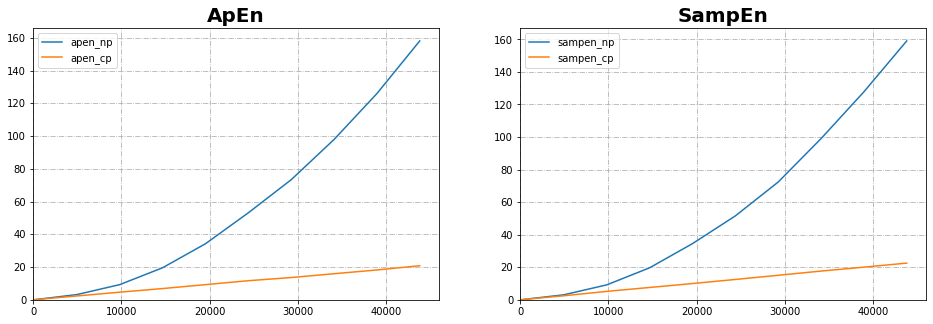

In [304]:
import matplotlib.pyplot as plt

algos = ['ApEn', 'SampEn']
fig, axs = plt.subplots(1, 2, figsize=(16,5))

for index, algo in enumerate(algos):
  algo_np = f'{algo.lower()}_np'
  algo_cp = f'{algo.lower()}_cp'
  axs[index].plot(kf['samples'], kf[[algo_np]], label=algo_np)
  axs[index].plot(kf['samples'], kf[[algo_cp]], label=algo_cp)
  axs[index].legend()
  axs[index].set_title(algo, fontweight='bold', fontsize=20)
  axs[index].set_xlim(xmin=0)
  axs[index].set_ylim(ymin=0)
  axs[index].set_xlabel('samples')
  axs[index].set_ylabel('time [seconds]')
  axs[index].grid(True, linestyle='dashdot')

## Cálculos de ```ApEn``` y ```SampEn``` variando los parámetros $r$ y $m$

### Obtención de ```df``` con todas las métricas

In [19]:
from tqdm import tqdm

r_min = 0.0
r_max = 0.25
m_min = 1
m_max = 4

SLICES = 50
my_list = []

# entropy frame
ef = fsi.DEF
#ef = df.pollution
N_SAMPLES = len(ef)

for r in tqdm(np.linspace(r_min, r_max, SLICES)):
  for m in range(m_min, m_max+1):
    u, m_value, r_value = params_entropy(ef[:N_SAMPLES], m, r)
    #print(f'm:{m_value}, r:{r_value:.2f}')
    my_list.append([m,
                    r_value,
                    apen_cp(u,m_value,r_value),
                    sampen_cp(u,m_value,r_value)])

100%|██████████| 50/50 [04:59<00:00,  6.00s/it]


In [30]:
# Create df
gf = pd.DataFrame(my_list, columns=['m', 'r', 'apen', 'sampen'])
gf[gf.m==1]

,m,r,apen,sampen
0,1,0.000000,3.263891370010437,4.002770798588631
4,1,0.128614,3.263891370010437,4.002770798588631
8,1,0.257228,3.263891370010437,4.002770798588631
12,1,0.385842,3.263891370010437,4.002770798588631
16,1,0.514456,3.263891370010437,4.002770798588631
20,1,0.643069,3.263891370010437,4.002770798588631
24,1,0.771683,3.263891370010437,4.002770798588631
28,1,0.900297,3.263891370010437,4.002770798588631
32,1,1.028911,3.063057746902015,3.0191642743604006
36,1,1.157525,3.063057746902015,3.0191642743604006


In [33]:
import sys

# Discard invalid values
gf.apen = gf.apen.apply(lambda x: x if 0<x<sys.float_info.max else np.nan)
gf.sampen = gf.sampen.apply(lambda x: x if 0<x<sys.float_info.max else np.nan)
gf.dropna(inplace=True)

In [23]:
# Save df
gf.to_csv('entropy_fsi.csv')

### Gráfico ```ApEn``` vs ```SampEn```
Por $m$ y $r$.

#### Dataset de polución

In [68]:
ef = pd.read_csv('entropy_pollution.csv', index_col=0)
ef

,m,r,apen,sampen
0,1,0.000000,3.377305,1.297622
1,2,0.000000,1.310375,0.221300
2,3,0.000000,0.229974,0.093143
3,4,0.000000,0.039155,0.087026
4,1,0.470670,3.377305,1.297622
...,...,...,...,...
195,4,22.592136,0.511220,0.208396
196,1,23.062806,0.552724,0.305385
197,2,23.062806,0.533973,0.253147
198,3,23.062806,0.514007,0.223860


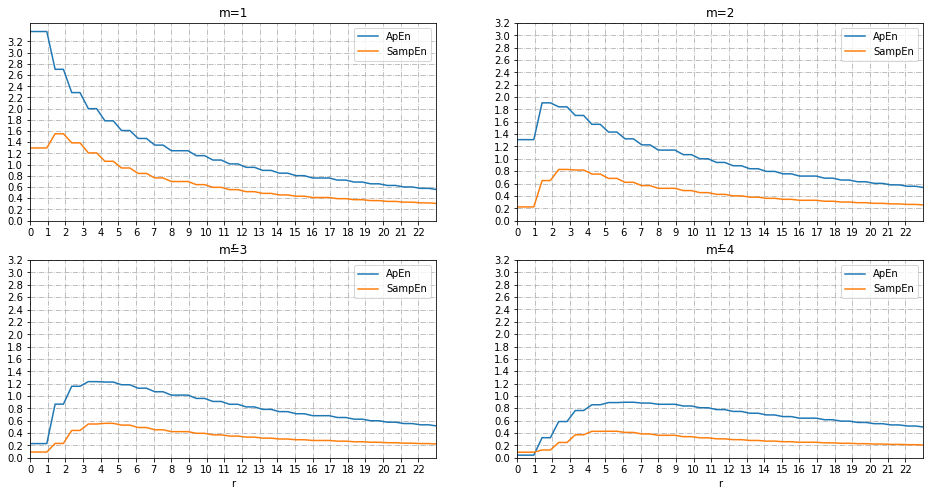

In [336]:
from math import ceil
algos = ['ApEn', 'SampEn']

fig, axs = plt.subplots(2, 2, figsize=(16,8))
max_x = round(max(gf.r))
max_y = round(float(max(gf.apen.append(gf.sampen))),1)
slices_y = int(max_y*10+1)

for m in range(m_min, m_max+1):
  for algo in algos:
    row = int(format(m-1, "b").zfill(2)[0])
    col = int(format(m-1, "b").zfill(2)[1])
    axs[row][col].plot(gf[gf.m==m]['r'], gf[gf.m==m][algo.lower()], label=algo)
    axs[row][col].legend()
    axs[row][col].set_title(f'm={m}', fontsize=12)
    axs[row][col].set_xlabel('r')
    axs[row][col].set_xticks(np.arange(0, max_x, step=1))
    axs[row][col].set_yticks(np.arange(0, max_y, step=0.2))
    axs[row][col].set_xlim(xmin=0, xmax=max_x)
    axs[row][col].grid(True, linestyle='dashdot')

#### Dataset FSI

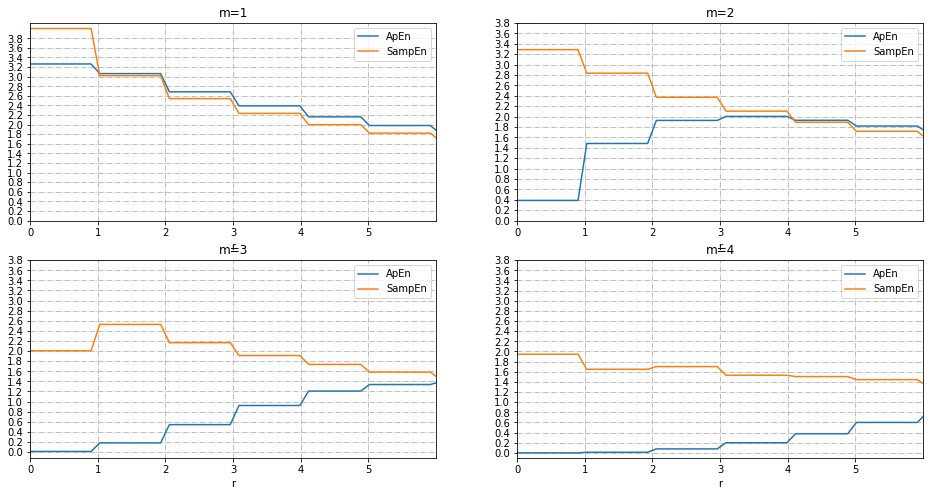

In [34]:
from math import ceil
algos = ['ApEn', 'SampEn']

fig, axs = plt.subplots(2, 2, figsize=(16,8))
max_x = round(max(gf.r))
max_y = round(float(max(gf.apen.append(gf.sampen))),1)
slices_y = int(max_y*10+1)

for m in range(m_min, m_max+1):
  for algo in algos:
    row = int(format(m-1, "b").zfill(2)[0])
    col = int(format(m-1, "b").zfill(2)[1])
    axs[row][col].plot(gf[gf.m==m]['r'], gf[gf.m==m][algo.lower()], label=algo)
    axs[row][col].legend()
    axs[row][col].set_title(f'm={m}', fontsize=12)
    axs[row][col].set_xlabel('r')
    axs[row][col].set_xticks(np.arange(0, max_x, step=1))
    axs[row][col].set_yticks(np.arange(0, max_y, step=0.2))
    axs[row][col].set_xlim(xmin=0, xmax=max_x)
    axs[row][col].grid(True, linestyle='dashdot')

### Gráfico FSI *vs* Pollution
En base a los datos recabados anteriormente creamos un ```df``` para realizar el ploteo.

In [131]:
pd.options.display.float_format = '{:,.3f}'.format

In [132]:
hf = pd.DataFrame()
hf = pd.concat([gf.groupby(['m']).apen.max().to_frame().\
           assign(dataset='fsi', algo='apen').\
           rename(columns={'apen':'score'}),
           gf.groupby(['m']).sampen.max().to_frame().\
           assign(dataset='fsi', algo='sampen').\
           rename(columns={'sampen':'score'}),
           ef.groupby(['m']).apen.max().to_frame().\
           assign(dataset='pollution', algo='apen').\
           rename(columns={'apen':'score'}),
           ef.groupby(['m']).sampen.max().to_frame().\
           assign(dataset='pollution', algo='sampen').\
           rename(columns={'sampen':'score'})])

In [133]:
hf.score = hf.score.astype(float)
hf

,score,dataset,algo
m,,,
1,3.264,fsi,apen
2,2.003,fsi,apen
3,1.388,fsi,apen
4,0.777,fsi,apen
1,4.003,fsi,sampen
2,3.286,fsi,sampen
3,2.527,fsi,sampen
4,1.946,fsi,sampen
1,3.377,pollution,apen


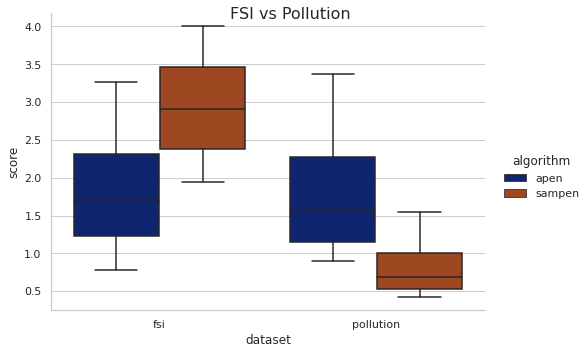

In [125]:
ax = sns.catplot(
    data=hf, 
    kind="box",
    x="dataset", 
    y="score", 
    hue="algo",
    ci="sd", 
    palette="dark",
    height=5,
    aspect=11.7/8.27
)

# Set title
ax.fig.suptitle(f"FSI vs Pollution",
                fontsize=16,
                fontdict={"weight": "bold"})
ax.legend.set_title("algorithm")
ax.tight_layout()